# Neoclassical growth model

This is a simple version of the standard neoclassical growth model with a public sector. Output now will be allocated to consumption and investment, however the government can demand goods, as well:

$$y_t = c_t + i_t + g_t$$

The government finances it's expenditure by distortionary taxation or by debt, so that it's budget constraint reads:

$$\bar{g} + (1+r_t)b_t = \tau^w_t w_t + \tau^r r_ta_t + b_{t+1}$$

We assume that government expenditure is fixed at the level of $\bar{g} = g_y [\frac{\alpha \beta}{1-\beta(1-\delta))}]^{\frac{\alpha}{1-\alpha}}$, where $g_y$ is given exogeneously. The tax rate on capital income is constant, while the tax rate on wages adjusts each period to balance the budget. The household solves the following decentralized equilibrium :

$$\sum_{t=0}^{\infty} \beta^t u(c_t) \\
\textrm{s.t. } \quad a_{t+1} + c_t = [1+(1-\tau^r)r_t] a_t + (1-\tau^w)w_t \\
a_t = k_t + b_t \\
y_t = c_t + i_t + g_t$$

We assume that the functional form on utiltiy is CRRA $u(c) = \frac{c^{1-\frac{1}{\gamma}}}{1-\frac{1}{\gamma}}$. Writing the problem recursively, we then need to solve the dynamic problem:

$$V(k_t) = \max_{c_t} \frac{c_t^{1-\frac{1}{\gamma}}}{1-\frac{1}{\gamma}} + \beta V(k_{t+1}) \\
\textrm{s.t. } \quad a_{t+1} + c_t = [1+(1-\tau^r)r_t] a_t + (1-\tau^w)w_t$$

The first order condition of this problem results into the Euler equation:

$$c_t = [\beta(1+(1-\tau^r)(r_t-\delta))]^{-\gamma}c_{t+1}$$

We can use the good market equilibrium $y_t = c_t + i_t + g_t$ and the definition of investment $i_t = k_{t+1} + (1-\delta)k_t$ to define the new accumulation equation of capital:

$$k_{t+1} = k_t^\alpha + (1-\delta)k_t - c_t - \bar{g}$$

We can use this equation to substitute into the euler equation:

$$k_t^{\alpha} - k_{t+1} + (1-\delta)k_t - \bar{g} - [\beta(1+(1-\tau^r_t)(\alpha k_{t+1}^{\alpha-1}-\delta))]^{-\gamma} c(k_{t+1}) = 0$$

Where $ \tau^w = \frac{\bar{g} + (1+r_t)b_t - b_{t+1} - \tau^r r_t(k_t + b_t)}{w_t}$ defines the tax on labor. Using interpolation, we can solve the last equation for each level of $k_{t+1}$.

In [1]:
import numpy as np
import scipy.interpolate as interp
import scipy.optimize as opt
import time
import sys
import matplotlib.pyplot as plt

In [2]:
# Setting up the values for the model
parameters = np.zeros(7)
parameters[0] = 0.4         # Alpha
parameters[1] = 0.99        # Beta
parameters[2] = 0.5         # Gamma
parameters[3] = 0.019       # Delta
parameters[4] = 0.00        # Exogeneous level of government expenditure
parameters[5] = 0.0         # Exogeneous level of capital taxation (positive values inticate taxation)
parameters[6] = 1.0         # Exogeneous level of government debt

# Printing the kss for setting up the grids sensible
kss1 = (parameters[0]*parameters[1]*(1-parameters[5])/(1-parameters[1]+parameters[1]*parameters[3]*(1-parameters[5])))**(1/(1-parameters[0]))
kss2 = (parameters[0]*parameters[1]/(1-parameters[1]*(1-parameters[3])))**(1/(1-parameters[0]))
css = kss1**parameters[0] - parameters[3]*kss1 - parameters[4]*kss2**parameters[0]
print("The steady state value for capital is %F." % kss1)
print("\nThe steady state without a public sector is %F." %kss2)

# To ensure convergence we use a guess for the policy function which is already quite close to the real one
adapt = kss1/css            # We have to adjust the guess to ensure convergence

# Setting up the values for the grid
kmin = 5
kmax = 105
knum = 500

if kss1 > kmax or kss1 < kmin:
    sys.exit("The grid must contain the steady state. Adapt kmax and kmin accordingly.")
elif kmax < kss2 or kmin > kss2:
    sys.exit("The grid must contain the steady state without government expenditure. Adapt kmax and kmin accordingly.")
    

# Setting up the time periods for the simulation of the trajectory
T = 3600

The steady state value for capital is 78.871460.

The steady state without a public sector is 78.871460.


In [3]:
# Create a grid for capital

def initialize(start, end, n, guess = 0):
    """Function initializing the capital grid and an initial guess for the value function
    
    Inputs:
    start         = start value for the capital grid
    end           = end point for the capital grid
    n             = number of grid points for the grid
    guess         = Initial guess for the value function
    
    
    Outputs:
    capital       = discretized capital grid
    value         = initial guess for the value function"""
    
    
    capital = np.linspace(start, end, n)
    value = np.ones((n,))*guess
    
    return capital, value


# Testing areas
capital, value = initialize(kmin, kmax, knum)

The policy function iterates on the Euler equation and makes it zero:

$$k_t^{\alpha} - k_{t+1} + (1-\delta)k_t - \bar{g} - [\beta(1+(1-\tau^r_t)(\alpha k_{t+1}^{\alpha-1}-\delta))]^{-\gamma} c(k_{t+1}) = 0$$

In [4]:
# Initial guess for the policy function
guess = capital/adapt

def euler(cap, guess, capital, parameters):
    """Function giving back the exact value for future capital which solves the first order condition
    
    Inputs:
    
    cap     =      value for capital for which the euler equation is evaluated
    guess   =      guess for the policy function in form of a numpy array
    capital =      matrix for capital, used in the interpolation
    
    
    Output:
    
    loc     =      value for future capital which solves the euler equation
    
    """
    
    alpha = parameters[0]
    beta = parameters[1]
    gamma = parameters[2]
    delta = parameters[3]
    gy = parameters[4]
    taur = parameters[5]
    kss1 = (alpha*beta*(1-taur)/(1-beta+beta*delta*(1-taur)))**(1/(1-alpha))
    kss2 = (alpha*beta/(1-beta*(1-delta)))**(1/(1-alpha))
    gbar = gy*kss2**alpha
    
    # Interpolating over the policy function
    tck = interp.splrep(capital, guess)
    y_app_spl = lambda x: interp.splev(x, tck)
    
    # Evaluating the residual as a function of future capital
    res = lambda cap1: cap**alpha - cap1 + (1-delta)*cap - gbar - (beta*(1+(1-taur)*(alpha*cap1**(alpha-1)-delta)))**(-gamma)*y_app_spl(cap1)
    loc = opt.fsolve(res, kss1)        # We use kss1 here, since this makes the optimization more stable
    return loc

# Testing area
alpha = parameters[0]
beta = parameters[1]
gamma = parameters[2]
delta = parameters[3]
gy = parameters[4]
taur = parameters[5]

kss1 = (alpha*beta*(1-taur)/(1-beta+beta*delta*(1-taur)))**(1/(1-alpha))
kss2 = (alpha*beta/(1-beta*(1-delta)))**(1/(1-alpha))
gbar = gy*kss2**alpha

# Extracting the optimal future capital
test1 = euler(kss1, guess, capital, parameters)
print("\nThe solution of the euler equation is %f " % test1)

# Interpolating over the capital grid to be able to continuously plug in the values for capital
tck = interp.splrep(capital, guess)
y_app_spl = lambda x: interp.splev(x, tck)

# Printing the residual of the euler equation
print("\nThe residual of the euler equation is %.10f" % (kss1**alpha - test1 + (1-delta)*kss1 - gbar - (beta*(1+(1-taur)*(alpha*test1**(alpha-1)-delta)))**(-gamma)*y_app_spl(test1)))


The solution of the euler equation is 78.871460 

The residual of the euler equation is 0.0000000000


#### Actual policy function iteration

In [5]:
# Policy function iteration
def pfi(capital, guess, parameters):
    """Definition of function"""
    
    
    start = time.time()
    new = np.copy(capital)
    iteration = 0
    error = 1
    gbar = (parameters[0]*parameters[1]/(1-parameters[1]*(1-parameters[3])))**(parameters[0]/(1-parameters[0]))*parameters[4]
    while error > 10**(-6):
        iteration += 1
    
        # Until convergence, generate a new policy function based on the current capital stock and the euler solution
        for index, k in enumerate(capital):
            # Generate a new policy function
            new[index] = k**parameters[0] - euler(k, guess, capital, parameters) + (1-parameters[3])*k - gbar
    
        # Calculating the error
        error = np.max((new - guess)/guess)
    
        # Updating the policy function which is employed in the next iteration round
        guess = np.copy(new)
    
    end = time.time()

    print("\nPolicy function iteration took %1.F iterations, and took %f seconds." % (iteration, end - start))
    return guess

# Testing area
guess = pfi(capital, guess, parameters)


Policy function iteration took 196 iterations, and took 60.613064 seconds.


Let's extract the policy function for capital.

In [6]:
# Guess is the policy function for consumption, now we need to extract the policy function for capital
policy = capital**alpha - guess + (1-delta)*capital - gbar

# Printing the policy function for consumption
print(policy[-10:])

[102.76782402 102.96457307 103.16132045 103.35806615 103.55481019
 103.75155256 103.94829328 104.14503234 104.34176976 104.53850554]


Having the policy function, we now can plot it.

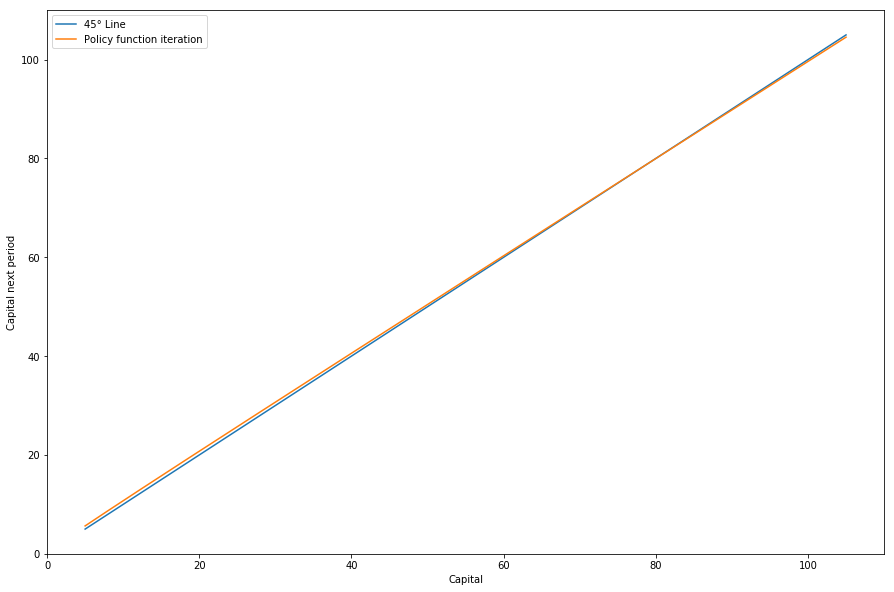

In [7]:
# Plotting the VFI, exact solution, and the policy function iteration solution
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(capital, capital, label = "45° Line")
ax.plot(capital, policy, label = "Policy function iteration")
ax.set_xlabel("Capital")
ax.set_ylabel("Capital next period")
ax.legend(loc = 2)
plt.show()

Next let's find the steady state. We do this by finding the root of an excess function:

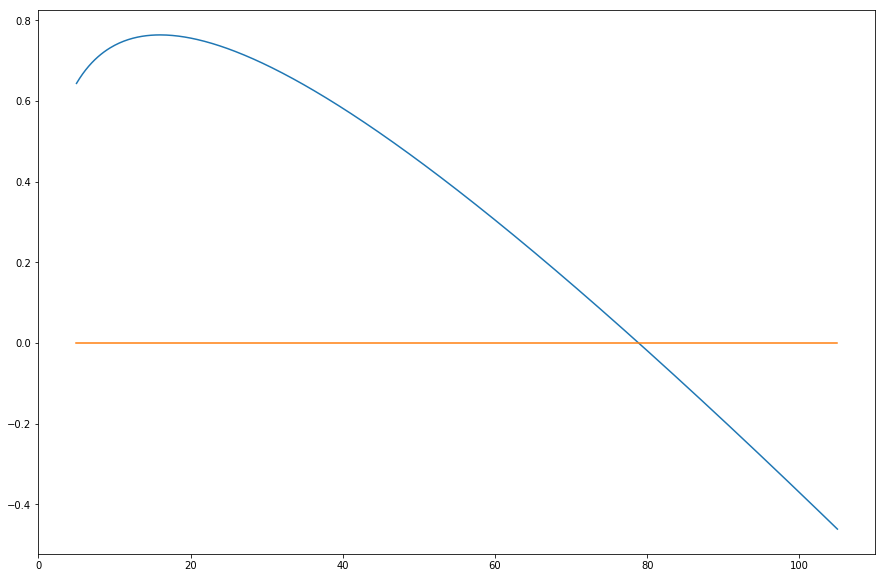

In [8]:
# To check, whether both generate the same steady state we find the root of the excess function:
def excess(pol, cap):
    ex = pol - cap
    return ex

# Generate the excess function
excess = excess(policy,capital)

# Plot the excess function
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(capital, excess, label = "Excess function")
ax.plot(capital, np.zeros(knum,))
plt.show()

In [9]:
# Let's find the root
tck = interp.splrep(capital, excess)
conexcess = lambda x: interp.splev(x, tck)

# Find the root
loc = opt.fsolve(conexcess, kss1)
print("The numerical steady state of the model is %F, while the true steady state is %F" % (loc, kss1))

The numerical steady state of the model is 78.871460, while the true steady state is 78.871460


Since we are rather satistfied with the precision, we now can simulate the economy.

In [10]:
# Defining a function to simulate different trajectories
def simulate(k0, parameters, T, policy, guess, kss):
    """Description of the function"""
    
    alpha = parameters[0]
    beta = parameters[1]
    gamma = parameters[2]
    delta = parameters[3]
    gy = parameters[4]
    taur = parameters[5]
    by = parameters[6]
    gbar = gy*kss**alpha
    
    # Discretizing the policy for capital functions to be continuous
    tck = interp.splrep(capital, policy)
    polcap = lambda x: interp.splev(x, tck)

    
    # Discretizing the policy for capital functions to be continuous
    tck = interp.splrep(capital, guess)
    polcon = lambda x: interp.splev(x, tck)

    
    # Setting up the arrays holding the time series of the simulated economy
    consumption = np.zeros(T)
    investment = np.zeros(T)
    output = np.zeros(T)
    capital1 = np.zeros(T+1)
    wage = np.zeros(T)
    interest = np.zeros(T)
    debt = np.zeros(T)
    tauw = np.zeros(T)
    
    capital1[0] = k0
    consumption[0] = polcon(capital1[0])
    output[0] = capital1[0]**alpha
    investment[0] = output[0] - consumption[0] - gbar
    wage[0] = (1-alpha)*capital1[0]**alpha
    interest[0] = alpha*capital[0]**(alpha-1) - delta
    debt[0] = 0
    
    for t in np.arange(1,T):
        capital1[t] = investment[t-1] + (1-delta)*capital1[t-1]
        consumption[t] = polcon(capital1[t])
        output[t] = capital1[t]**alpha
        investment[t] = output[t] - consumption[t] - gbar
        wage[t] = (1-alpha)*output[t]
        interest[t] = alpha*capital1[t]**(alpha-1) - delta
        debt[t] = by*output[t]
        tauw[t-1] = (gbar+(1+interest[t-1])*debt[t-1]-debt[t] - taur*interest[t-1]*(capital1[t-1]+debt[t-1]))/wage[t-1]
        
    tauw[T-1] = tauw[T-2]
    
    # Caculating the steady state utility level
    UU = consumption[T-1]**(1-1/gamma)/(1-1/gamma)/(1-beta)
    
    # Calculating the utility level with transition
    UU_0 = 0
    for t in range(0,T):
        UU_0 = UU_0 + beta**t/(1-1/gamma)*consumption[t]**(1-1/gamma)
    
    # Taking into account the steady state value 
    UU_0 = UU_0 + beta**T*UU
    
    return consumption, investment, output, capital1, wage, interest, debt, tauw, UU, UU_0

# Simulating the time series behavior
con, inv, out, cap, wage, interest, debt, tauw, UU, UU_0 = simulate(kss2, parameters, T, policy, guess, kss2)

# Calculating the steady state utility in comparison
uu = kss1**alpha - delta*kss1
uu = 1/(1-beta)*uu**(1-1/gamma)/(1-1/gamma)


# Reporting the utility measures
print("The long-run level of labor taxation is %F percent." % (tauw[T-2]*100))
print("\nThe annualized capital output ratio is %F." % (cap[T-1]**(1-alpha)/4*100))
print("\nThe consumption output ratio is %F." %(con[T-1]/out[T-1]*100))
print("\nThe long-run utility is %F, whereas the utility over the lifetime is %F " % (UU, UU_0))
print("\nTherefore, the utility decreased due to government policy by %F percent" % ((UU-uu)/uu*100))

The long-run level of labor taxation is 1.683502 percent.

The annualized capital output ratio is 343.630684.

The consumption output ratio is 73.884068.

The long-run utility is -23.587464, whereas the utility over the lifetime is -23.587464 

Therefore, the utility decreased due to government policy by 0.000000 percent


The utility measures reported above are the following:

$$Long-run: \sum_{t=0}^{\infty} \beta^t \frac{c^{1-\frac{1}{\gamma}}}{1-\frac{1}{\gamma}} = \frac{1}{1-\beta}\frac{c^{1-\frac{1}{\gamma}}}{1-\frac{1}{\gamma}} \\ \\
Trajectory: \quad U_0 = \sum_{t=0}^{\infty} \beta^t \frac{c_t^{1-\frac{1}{\gamma}}}{1-\frac{1}{\gamma}}$$

The long-run measure assumes that consumption stays at the steady state and is constant, whereas $U_0$ takes into consideration the whole trajectory of the economy. The calibration of the values of the economy are in quarters. Therefore, to annualize the capital to output ratio, we used the following formula $\frac{k}{4y} = \frac{k}{4k^\alpha} = \frac{1}{4}k^{1-\alpha}$.



Using the simulated behavior, we now can plot the development of different economies with different public sector.

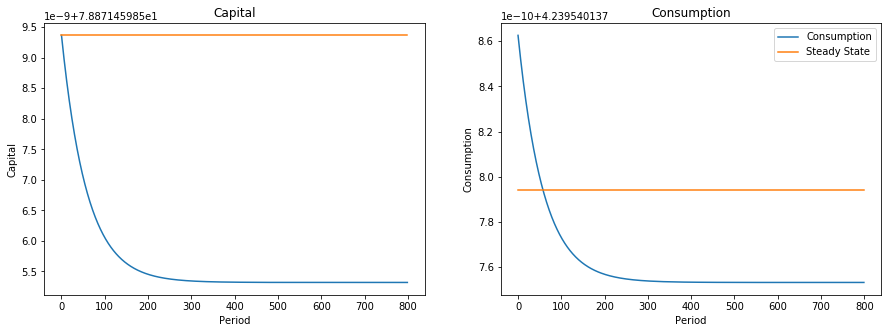

In [11]:
# Defining a time sequence and a vector with the kss
t = np.arange(0,800)
vkss = np.zeros(T)
vcss = np.zeros(T)
vkss[:] = kss2
vcss[:] = kss2**alpha - gbar - delta*kss2

# Plot the excess function
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))
axes[0].plot(t, cap[0:800])
axes[0].plot(t, vkss[0:800], label = "Steady State")
axes[0].set_title("Capital")
axes[0].set_xlabel("Period")
axes[0].set_ylabel("Capital")

axes[1].plot(t, con[0:800], label = "Consumption")
axes[1].plot(t, vcss[0:800], label = "Steady State")
axes[1].set_title("Consumption")
axes[1].set_xlabel("Period")
axes[1].set_ylabel("Consumption")
axes[1].legend(loc=1)

plt.show()

Let's plot the phase diagram, showing the saddle path for the economy to transit to the steady state. The phase diagram shows the convergence path of the economy, and the function of values for which consumption and capital are constant. Consumption is constant, when capital is at it's steady state value. However, capital is constant, if the difference in capital between periods, is zero.

$$k_{t+1} = (1-\delta)k_t + i_t\\
k_{t+1} - k_t = i_t - \delta k_t \\
0 = i_t - \delta k_t \\
i_t = \delta k_t \\
y_t - c_t - \bar{g}= \delta k_t \\
c_t = y_t - \delta k_t - \bar{g}$$

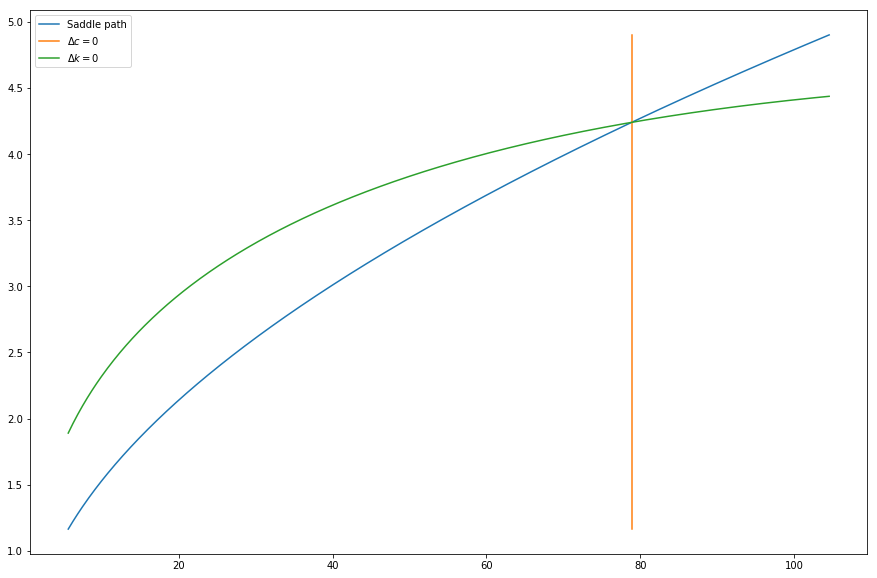

In [12]:
# Setting up some arrays
vkss = np.zeros(knum)
vkss[:] = kss1              # Array for the value where consumption is constant
css = policy**alpha - delta*policy - gbar

# Plotting the phase diagram
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(policy, guess, label = "Saddle path")
ax.plot(vkss, guess, label = r"$\Delta c = 0$")
ax.plot(policy, css, label = r"$\Delta k = 0$")
ax.legend(loc=2)
plt.show()

When we compare this measure with the economy without a public sector, we see that the steady state changed due to the government interventions.

### Euler equation residual

THe euler equation residual is a way to compute the error we have in our approximation with the policy function.

$$EER(k) = S(k_t) - [\beta(1+(1-\tau^r)(\alpha(k_{t+1})^{\alpha-1}-\delta))]^{-\gamma}S(k_{t+1}) \\
\textrm{with } k_{t+1} = (1-\delta)k_t + k_t^\alpha - S(k_t)$$

Where $S(k_t)$ is the continuous policy function.

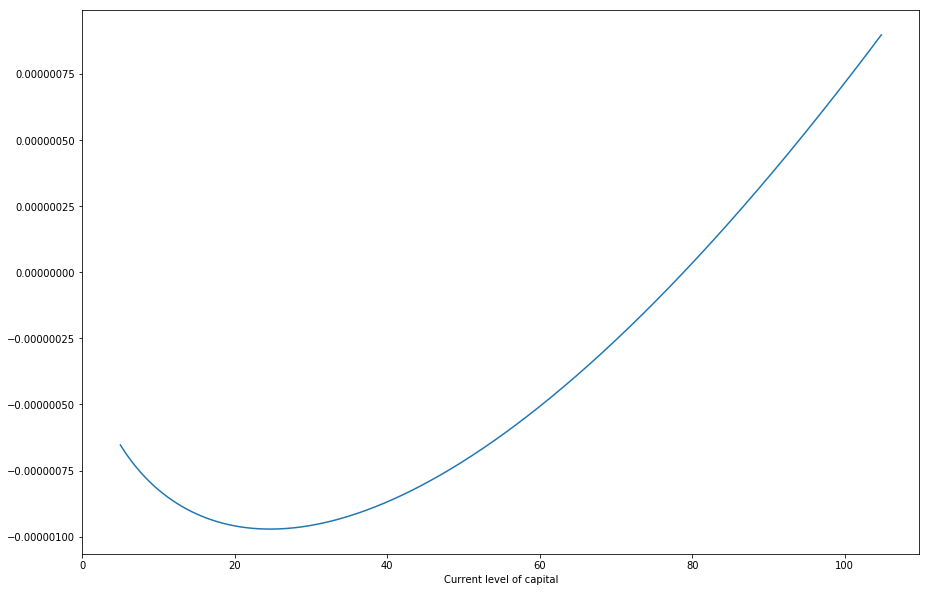

In [13]:
# Interpolating the policy function
tck = interp.splrep(capital, guess)
pol = lambda x: interp.splev(x, tck)

# Using the interpolated policy function to compute the EER
EER = lambda k: pol(k)-((beta*((1+(1-taur)*(alpha*((1-delta)*k+k**alpha-pol(k)-gbar)**(alpha-1)-delta))))**(-gamma))*pol((1-delta)*k+k**alpha-pol(k)-gbar)
EEE = lambda k: (EER(k)/pol(k))

# Setting up the spacing of the grid for which we want to analyze the euler equation error (EEE)
m = (kmax-kmin)/knum

# Setting up the capital grid and calculating the error
k = np.arange(kmin,kmax,m)
error = np.zeros(knum)
for index, cap in enumerate(k):
    error[index] = EEE(cap)

# Plotting the EEE
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(k, error, label = "Euler equation error")
ax.set_xlabel("Current level of capital")
plt.show()

The euler equation error is actually defined as:

$$\max_k |\frac{EER(k)}{S(k)}|$$

It's economic interpretation is as follows: If an agent makes a decision on the allocation of 1000€, using the approximated decision rules, he would make an error of $1000*\max_k |\frac{EER(k)}{S(k)}|$€.

In [14]:
print("The euler equation error is %F" % np.amax(np.abs(error)))
print("\nThis results in an error for the agent of %F €" % np.amax(np.abs(1000*error)))

The euler equation error is 0.000001

This results in an error for the agent of 0.000971 €


As a result, the EEE is really small. This showes that our approximation is rather good.